<a href="https://colab.research.google.com/github/rongxie2023/dlcv/blob/main/Chapter02/Chapter02/08-case2-iou.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

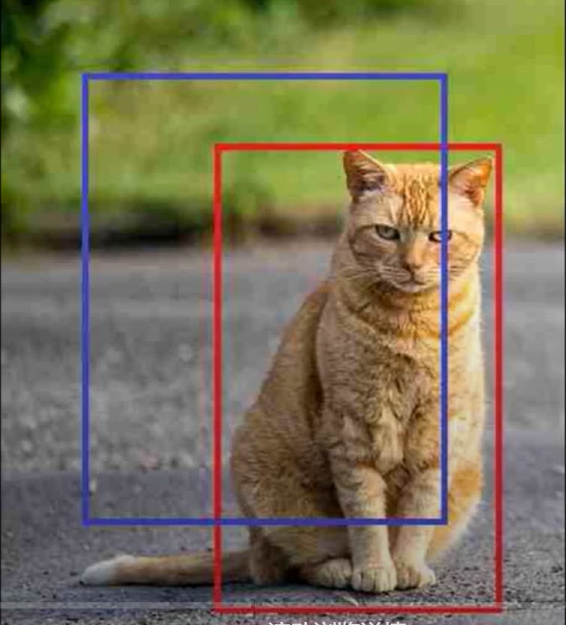

In [7]:
'''

计算 IoU:
    # 计算两个框的交集
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # 计算两个框的并集
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # 计算 IoU
    iou = intersection_area / union_area if union_area > 0 else 0


例如：
box1 = [10, 10, 50, 50]
box2 = [20, 20, 60, 60]
交集区域的左上角坐标 (x1i, y1i) = (20, 20)
交集区域的右下角坐标 (x2i, y2i) = (50, 50)
交集区域面积 intersection_area = (50 - 20) * (50 - 20) = 30 * 30 = 900
box1 的面积 area_a = (50 - 10) * (50 - 10) = 40 * 40 = 1600
box2 的面积 area_b = (60 - 20) * (60 - 20) = 40 * 40 = 1600
并集区域面积 union_area = 1600 + 1600 - 900 = 2300
IoU iou = 900 / 2300 ≈ 0.39
'''

'\n\n计算 IoU:\n    # 计算两个框的交集\n    x1 = max(box1[0], box2[0])\n    y1 = max(box1[1], box2[1])\n    x2 = min(box1[2], box2[2])\n    y2 = min(box1[3], box2[3])\n\n    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)\n\n    # 计算两个框的并集\n    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])\n    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])\n    union_area = box1_area + box2_area - intersection_area\n\n    # 计算 IoU\n    iou = intersection_area / union_area if union_area > 0 else 0\n\n\n例如：\nbox1 = [10, 10, 50, 50]\nbox2 = [20, 20, 60, 60]\n交集区域的左上角坐标 (x1i, y1i) = (20, 20)\n交集区域的右下角坐标 (x2i, y2i) = (50, 50)\n交集区域面积 intersection_area = (50 - 20) * (50 - 20) = 30 * 30 = 900\nbox1 的面积 area_a = (50 - 10) * (50 - 10) = 40 * 40 = 1600\nbox2 的面积 area_b = (60 - 20) * (60 - 20) = 40 * 40 = 1600\n并集区域面积 union_area = 1600 + 1600 - 900 = 2300\nIoU iou = 900 / 2300 ≈ 0.39\n'

In [8]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]  # ... 可以帮助你保留前面的维度
        box1_y1 = boxes_preds[..., 1:2]  # 后面用切片才能保持取出来是列的形状
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)   #分母加上一个很少的数值，避免分母为0

In [9]:
preds=torch.tensor([[10, 10, 50, 50],[30, 30, 70, 70],[5, 5, 55, 55],[0, 0, 40, 40],[10, 10, 90, 90]])
labels=torch.tensor([[20, 20, 60, 60],[40, 40, 80, 80], [15, 15, 65, 65],[20, 20, 60, 60],[20, 20, 80, 80]])
iou=torch.tensor([0.39,0.39,0.47,0.14,0.56])

print(preds)
print(labels)
print(iou)
res=intersection_over_union(preds,labels,box_format="corners")
print(res)

tensor([[10, 10, 50, 50],
        [30, 30, 70, 70],
        [ 5,  5, 55, 55],
        [ 0,  0, 40, 40],
        [10, 10, 90, 90]])
tensor([[20, 20, 60, 60],
        [40, 40, 80, 80],
        [15, 15, 65, 65],
        [20, 20, 60, 60],
        [20, 20, 80, 80]])
tensor([0.3900, 0.3900, 0.4700, 0.1400, 0.5600])
tensor([[0.3913],
        [0.3913],
        [0.4706],
        [0.1429],
        [0.5625]])
